In [18]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
        
    def give_transition_matrix(self,melody):
        lookup = np.empty((len(melody)))
        lookup[list(range(1,len(melody)+1))] = np.arange(len(melody))
        counts = np.zeros((5,5))
        np.add.at(counts, (melody[:-1], melody[1:]),1 )
        probs = counts/counts.sum(axis=0, keepdims=True)
        self.transitions.append(probs)
        return probs
    

class Evaluator():
    def __init__(self):
        self.reward_history = []
        self.trajectories = []
    def give_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
    def give_reward_melody(self, guess, label):
        r=[]
        for g,l in zip(guess, label):
            if g==l:
                r.append(1)
            else:
                r.append(0)
        return np.array(r)
        
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01):
        self.n_actions = notes_to_choose
        self.states = notes_to_choose
        self.q = np.ones((notes_to_choose, notes_to_choose))
        self.n = np.ones((notes_to_choose, notes_to_choose))
        self.epsilon = ep
        self.gamma = gamma
        
    def give_action(self, state, playing=False,T=0.05):
        if playing is True:
            probs = self.q[state]/np.sum(self.q[state])
            probs = np.exp(-probs/T)/np.sum(np.exp(-probs/T))
            return np.random.choice(range(self.n_actions), 1, p=probs)[0]
        
        if np.random.random()<self.epsilon:
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[:,state]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]
            

    def q_learn(self, ts):
        ### q-learn
        for interaction in ts:
            s, a, r, ns = interaction
            self.n[s,a]+=1
            lr = 1/self.n[s,a]
            if ns != -1:
                self.q[s,a] += (r+ agent.gamma*np.max(self.q[ns,:]))*lr
            else:
                self.q[s,a] += (r-self.q[s,a])*lr
                
    def decrease_ep(self,ind):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/100), 0.01)
        return

100%|██████████| 10000/10000 [00:04<00:00, 2052.59it/s]


Text(0, 0.5, 'Cumulative reward ($\\frac{Success}{TOTAL}$)')

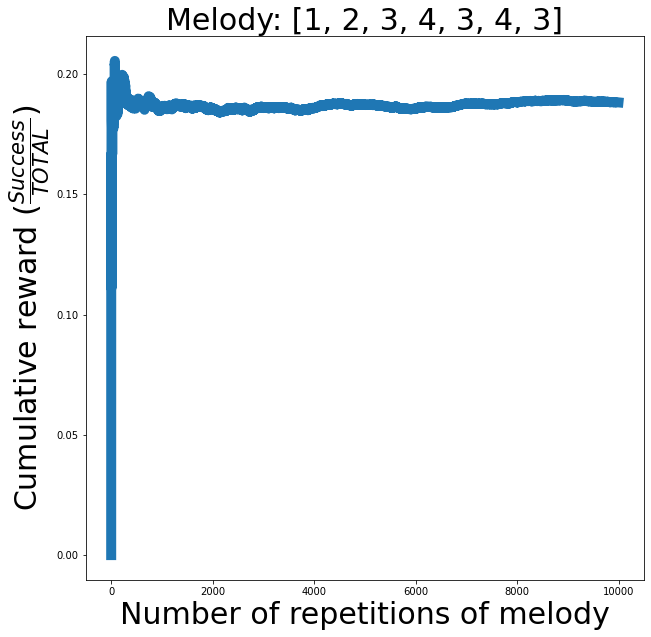

In [29]:
evaluator = Evaluator()
agent = Agent(5, gamma=0.5, ep=0.1)
melody = [1,2,3,4,3,4,3]


for episode in tqdm(range(10**4)):
    state = melody[0]
    ts=[]
    states, next_states, actions, rewards = [], [], [], []
    for ind,note in enumerate(melody):
        
        states.append(state)
        action = agent.give_action(state, playing=True, T=0.1)
        actions.append(action)
        if ind!=len(melody)-1:
            next_state = action
            next_states.append(next_state)
        else:
            next_state = -1
            next_states.append(next_state)
            evaluator.reward_history.append(np.sum(rewards)/len(rewards))

        reward = evaluator.give_reward(action, note)
        rewards.append(reward)
        ts.append([state, action, reward, next_state])
        state = next_state
        
    agent.q_learn(ts)
    #agent.decrease_ep(episode)
    evaluator.trajectories.append(actions)

plt.figure(figsize=(10,10))
plt.title("Melody: {}".format(melody),size=30)
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=10)
plt.xlabel("Number of repetitions of melody",size=30)
plt.ylabel("Cumulative reward ("+r'$\frac{Success}{TOTAL}$'+")",size=30)

In [36]:
state=melody[0]
note_player=[state]
for ind,note in enumerate(melody):
    agent.epsilon=0
    note_player.append(agent.give_action(state, playing=False))#, T=1e-10))
    state = note_player[-1]

In [37]:
note_player

[1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
agent.q

array([[0.        , 0.        , 0.        , 0.        , 1.78333333],
       [0.        , 1.0385632 , 0.39285714, 1.79090909, 0.5       ],
       [0.        , 0.        , 0.46153846, 0.52063492, 0.33333333],
       [0.        , 0.        , 0.5       , 1.11666667, 1.        ],
       [0.        , 0.        , 0.        , 0.83333333, 0.5       ]])

In [212]:
os.makedirs("rl_trajs_more", exist_ok=True)
os.system("rm -r rl_trajs_more/*")

for ind,p in enumerate(evaluator.trajectories):
    dictionary={"notas1":[66,64,60,70,62], "weight":p}
    dd = pd.DataFrame.from_dict(dictionary, orient="index")
    dd.to_csv("rl_trajs"+"/episode_{}".format(ind), header=False)

In [193]:
len(evaluator.trajectories)


30